# Safaricom Tweets Classification for complaints & Hate Speech Detection

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# nltk libraries
import nltk
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

## Load the dataset

In [2]:
# load dataset
from data_prep.data_loader import DataLoader # custom class

# define a loader variable
loader = DataLoader('data/combined_safaricom_data.csv')
data = loader.load_data()

Dataset loaded successfully from data/combined_safaricom_data.csv


In [3]:
# check the dataset info and shape
loader.check_dataset_info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5283 entries, 0 to 5282
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tweet ID  5270 non-null   float64
 1   URL       5270 non-null   object 
 2   Content   5270 non-null   object 
 3   Likes     5283 non-null   int64  
 4   Retweets  5283 non-null   int64  
 5   Replies   5283 non-null   int64  
 6   Quotes    5283 non-null   int64  
 7   Views     5283 non-null   int64  
 8   Date      5270 non-null   object 
 9   Labels    5282 non-null   object 
dtypes: float64(1), int64(5), object(4)
memory usage: 412.9+ KB
None

Dataset shape: (5283, 10)
Memory usage: 2.71 MB


In [4]:
# handle missing values
data = loader.handle_missing_values(strategy='comprehensive')
print(data.isnull().sum())

Handling missing values...
Original dataset shape: (5283, 10)
Found missing values in 5 columns:
  Tweet ID: 13 (0.25%)
  URL: 13 (0.25%)
  Content: 13 (0.25%)
  Date: 13 (0.25%)
  Labels: 1 (0.02%)
Dropping 13 rows with missing Tweet ID
Dropping 13 rows with missing URL
Dropping 13 rows with missing Content
Dropping 13 rows with missing Date
Dropping 1 rows with missing labels
✓ All missing values successfully handled!

Summary:
  Original rows: 5283
  Final rows: 5269
  Rows removed: 14
  Data retention: 99.73%
Tweet ID    0
URL         0
Content     0
Likes       0
Retweets    0
Replies     0
Quotes      0
Views       0
Date        0
Labels      0
dtype: int64


In [5]:
# check for duplicates
loader.check_duplicates()

Number of duplicate rows: 1569
Duplicate rows found. Consider removing them.


np.int64(1569)

In [6]:
# handle duplicate rows
loader.remove_duplicates()
loader.check_duplicates()

Removed 1569 duplicate rows.
Number of duplicate rows: 0
No duplicate rows found.


np.int64(0)

In [7]:
# check the distribution of the target variable
loader.analyze_target_distribution()

Distribution of the target variable:
Labels
Neutral                                 1094
Hate Speech                              828
Customer care complaint                  601
Internet or airtime bundle complaint     375
MPESA complaint                          282
Data protection and privacy concern      264
Network reliability problem              256
Name: count, dtype: int64


Labels
Neutral                                 1094
Hate Speech                              828
Customer care complaint                  601
Internet or airtime bundle complaint     375
MPESA complaint                          282
Data protection and privacy concern      264
Network reliability problem              256
Name: count, dtype: int64

In [8]:
# plot the distribution of the target variable
loader.plot_target_distribution()

In [9]:
# display a comprehensive summary of the dataset
# loader.get_dataset_summary()

## Feature Engineering, Data Cleaning, Preprocessing & Vectorization

In [10]:
# use the FeatureEngineering class for creating new features, data cleaning, data preprocessing and vectorization
from data_prep.feature_engineering import FeatureEngineering
fe = FeatureEngineering(data)
X_train_vec, X_test_vec, y_train, y_test, vectorizer = fe.process_pipeline()

Starting feature engineering pipeline...
Generating text features...
Added features: chars, words, sentences
Removed columns: ['Tweet ID', 'URL']
Cleaning text data...
Text cleaning completed.
Tokenizing text...
Tokenization completed.
Lemmatizing text...
Lemmatization completed.
Creating processed text...
Processed text creation completed.
Handling missing values in 'Labels' column...
Removed 0 rows with 'unknown' labels.


/home/patrick/Desktop/online_hate-speech_and_complaints_detection/data_prep/feature_engineering.py:221: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Processed data saved to data/cleaned_safaricom_data.csv
Prepared data for modeling:
Features shape: (3700, 12)
Target shape: (3700,)
Splitting data with test_size=0.2, random_state=42
Training set shape: (2960, 12)
Testing set shape: (740, 12)
Vectorizing text using COUNT vectorizer...
Training features shape: (2960, 5000)
Testing features shape: (740, 5000)
Vocabulary size: 5000
Feature engineering pipeline completed!


In [11]:
# Ensure that fe.processed_data is not None before saving
if fe.data is None:
    raise ValueError("Processed data is not available. Please ensure the preprocessing pipeline has been run successfully.")
else:
    safaricom_df = fe.data.copy()

safaricom_df.to_csv('data/cleaned_safaricom_data.csv', index=False)

## Modeling

In [12]:
# use the Modeling() class to train and evaluate all models
from data_prep.modeling import Modeling
modeler = Modeling()
results = modeler.train_and_evaluate_all_models(X_train_vec, y_train, X_test_vec, y_test)

Training and evaluating all models...
Training Logistic Regression model...


Logistic Regression model trained successfully.
Evaluating Logistic Regression...
Logistic Regression Results:
Accuracy: 0.5014
Precision: 0.5054
Recall: 0.5014
F1-Score: 0.5020

Classification Report:
                                      precision    recall  f1-score   support

             Customer care complaint       0.45      0.53      0.48       118
 Data protection and privacy concern       0.38      0.35      0.37        48
                         Hate Speech       0.56      0.51      0.53       176
Internet or airtime bundle complaint       0.50      0.44      0.47        71
                     MPESA complaint       0.52      0.47      0.49        58
         Network reliability problem       0.36      0.43      0.39        54
                             Neutral       0.55      0.57      0.56       215

                            accuracy                           0.50       740
                           macro avg       0.47      0.47      0.47       740
                

In [13]:
# compare all the models
modeler.compare_models()

Model Comparison:
              Model  accuracy  precision  recall  f1_score
Logistic Regression    0.5014     0.5054  0.5014    0.5020
        Naive Bayes    0.4878     0.5110  0.4878    0.4741
      Random Forest    0.4959     0.5026  0.4959    0.4845


,Model,accuracy,precision,recall,f1_score
0,Logistic Regression,0.501351,0.505401,0.501351,0.501951
1,Naive Bayes,0.487838,0.511017,0.487838,0.474124
2,Random Forest,0.495946,0.502578,0.495946,0.484543


In [12]:
# # cross-validation of the model
# # Initialize the logistic regression model
# lr_model = LogisticRegression(max_iter=1000, random_state=42)

# # Use the Modeling class's cross_validate_model method for cross-validation
# cv_results = modeler.cross_validate_model(lr_model, X_train_vec, y_train, cv=5)

# print("Logistic Regression 5-fold cross-validation results:", cv_results)

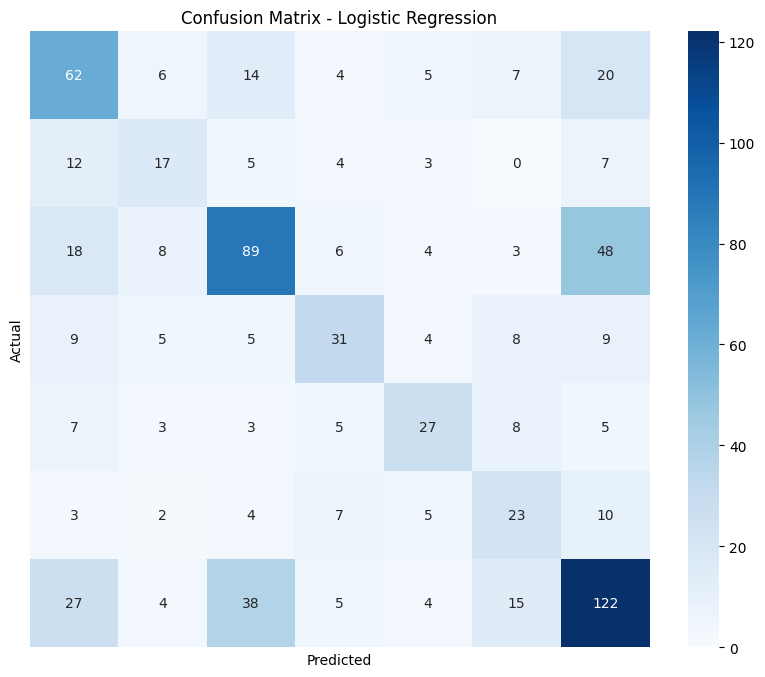

In [14]:
# plot the confusion matrix for the best model
modeler.plot_confusion_matrix()

In [15]:
# predict on some new tweets
test_tweets = [
    "Safaricom network is very slow today, I can't browse properly",
    "There have been so many abductions in the country and I bet Safaricom is sharing our information",
    "Thank you Safaricom for the great service today",
    "My MPESA transaction failed again, this is frustrating"
]
    
print("Testing predictions on sample tweets:")
for i, tweet in enumerate(test_tweets, 1):
    prediction = modeler.predict_new_text(tweet, vectorizer)
    print(f"{i}. Tweet: {tweet}")
    print(f"   Prediction: {prediction}")
    print()

Testing predictions on sample tweets:
1. Tweet: Safaricom network is very slow today, I can't browse properly
   Prediction: Network reliability problem

2. Tweet: There have been so many abductions in the country and I bet Safaricom is sharing our information
   Prediction: Data protection and privacy concern

3. Tweet: Thank you Safaricom for the great service today
   Prediction: Hate Speech

4. Tweet: My MPESA transaction failed again, this is frustrating
   Prediction: MPESA complaint

